# DEMO 

Example code to compute FFDI from a zarr store of one of RCM simulations

To fix

The code reads the intake catalogues of the SSP370 runs to get a list of models to process.  This is not necessary but it is a convenient way to get a list of all the files to process

Added the code to read info from command line or interactive 

Set the mindex in the 


#### required packages

In [2]:
import intake
import xarray as xr
from matplotlib import pyplot as plt

import glob
import pathlib
import traceback
from datetime import datetime

from xclim.indices import (
    keetch_byram_drought_index,
    griffiths_drought_factor,
    mcarthur_forest_fire_danger_index
)


#### start a local Dask client

In [3]:
from dask.distributed import Client
client = Client()
client

2024-06-15 21:01:01,070 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-06-15 21:01:01,073 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-06-15 21:01:01,079 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0077.gadi.nci.org.au/62128/proxy/8787/status,
Dashboard: /node/gadi-cpu-bdw-0077.gadi.nci.org.au/62128/proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40403,Workers: 28
Dashboard: /node/gadi-cpu-bdw-0077.gadi.nci.org.au/62128/proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:38749,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0077.gadi.nci.org.au/62128/proxy/39345/status,Memory: 0 B
Nanny: tcp://127.0.0.1:35157,


#### ignore warnings

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Example code to read from command line if not interactive
def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

from sys import argv

if is_interactive():
    params = [12, 36.4 ]
else:
    print(argv)
    ss=argv[1:]
    print(ss)
    params = [float(i) for i in ss]

print('Model Number=',params[0])

[12, 36.4]
Model Number= 12


## Obtain the desired catalogues of the simulations to processe

In [7]:
catalogue_path='/g/data/ia39/catalogues'
mRuns = sorted(glob.glob(catalogue_path+'/*ssp370*.json'))
print(len(mRuns))

13


In [8]:
# test loading all the catalogues of the data
for file in mRuns: 
    print(file)
    cat1=intake.open_esm_datastore(file)

/g/data/ia39/catalogues/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_BOM_ACCESS-ESM1-5_ssp370_r6i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_BOM_CESM2_ssp370_r11i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_BOM_CMCC-ESM2_ssp370_r1i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_BOM_EC-Earth3_ssp370_r1i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_BOM_MPI-ESM1-2-HR_ssp370_r1i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_BOM_NorESM2-MM_ssp370_r1i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_CSIRO_ACCESS-CM2_ssp370_r4i1p1f1_CCAM-v2203-SN_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_CSIRO_ACCESS-ESM1-5_ssp370_r6i1p1f1_CCAM-v2203-SN_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_CSIRO_CESM2_ssp370_r11i1p1f1_CCAM-v2203-SN_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_CSIRO_CMCC-ESM2_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1_day.json
/g/data/ia39/

# Process one ensemble 

In [28]:
# From one catalogue list save variables
#mindex=12  # run to process now set a start
mtmp=mRuns[mindex].split('/')
model_name=mtmp[5].split('.')
print(model_name)
tmp=model_name[0].split('_'); ACS_model=tmp[1]

# now match extract RCM_GCM info 
match=tmp[1]+'_'+tmp[2]
print(match)

['AGCD-05i_CSIRO_EC-Earth3_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1_day', 'json']
CSIRO_EC-Earth3


In [30]:
%%time
# read in the historical catalogue to compute 
catalogue_path='/g/data/ia39/catalogues'
mHis = sorted(glob.glob(catalogue_path+'/*'+match+'*hist*.json'))
print(len(mHis))
print(mHis[0])

cat1=intake.open_esm_datastore(mHis[0])
pr_his = cat1.search(variable={'pr'}).to_dask(cdf_kwargs={'chunks': {'time': 365, 'lat': 691, 'lon': 886}})
pr_his

# This is usually computed over a specific period
#pr_annual = dsets.pr.resample(time="A").sum().mean("time")
pr_annual = pr_his.pr.resample(time="Y").sum().\
    sel(time=slice('1985-01-01', '2015-01-01')).mean("time").\
    assign_attrs(
    units="mm a-1", long_name="Annual average rainfall")
pr_annual.load()
plt.subplot(2,2,1); pr_annual.plot()

1
/g/data/ia39/catalogues/AGCD-05i_CSIRO_EC-Earth3_historical_r1i1p1f1_CCAM-v2203-SN_v1-r1_day.json
CPU times: user 9 s, sys: 1.69 s, total: 10.7 s
Wall time: 31.3 s


<xarray.DataArray 'pr' (lat: 691, lon: 886)>
array([[1173.6057 , 1171.5623 , 1169.5175 , ...,  963.58124,  964.331  ,
         964.487  ],
       [1168.5607 , 1166.3768 , 1164.1792 , ...,  963.9776 ,  964.6065 ,
         964.44867],
       [1163.5094 , 1161.1815 , 1158.8557 , ...,  964.39844,  964.87134,
         964.3625 ],
       ...,
       [1349.8235 , 1348.3339 , 1346.8497 , ..., 2242.605  , 2255.4185 ,
        2268.7446 ],
       [1350.4653 , 1349.4362 , 1348.3704 , ..., 2269.0935 , 2281.3748 ,
        2296.3345 ],
       [1351.13   , 1350.512  , 1349.9037 , ..., 2295.5928 , 2307.336  ,
        2323.9417 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 112.0 112.0 112.1 112.2 ... 156.1 156.2 156.2 156.2
Attributes:
    units:      mm a-1
    long_name:  Annual average rainfall

In [33]:
#AGCD-05i_CSIRO_EC-Earth3_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1_day.zarr/
dir='/scratch/xv83/rxm599/'
file=dir+model_name[0]+'.zarr'
print(file)
ds0 = xr.open_zarr(file)
ds0

/scratch/xv83/rxm599/AGCD-05i_CSIRO_EC-Earth3_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1_day.zarr


<xarray.Dataset>
Dimensions:     (time: 31025, lat: 691, lon: 886, bnds: 2)
Coordinates:
  * lat         (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
    lat_bnds    (lat, bnds) float64 dask.array<chunksize=(33, 2), meta=np.ndarray>
  * lon         (lon) float64 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
    lon_bnds    (lon, bnds) float64 dask.array<chunksize=(43, 2), meta=np.ndarray>
  * time        (time) object 2015-01-01 12:00:00 ... 2099-12-31 12:00:00
    time_bnds   (time, bnds) object dask.array<chunksize=(31025, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    hursmin     (time, lat, lon) float32 dask.array<chunksize=(31025, 33, 43), meta=np.ndarray>
    pr          (time, lat, lon) float32 dask.array<chunksize=(31025, 33, 43), meta=np.ndarray>
    sfcWindmax  (time, lat, lon) float32 dask.array<chunksize=(31025, 33, 43), meta=np.ndarray>
    tasmax      (time, lat, lon) float32 dask.array<chunksize=(31025, 33, 43), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                         CF-1.10
    NCO:                                 netCDF Operators version 5.0.5 (Home...
    activity_id:                         DD
    contact:                             ccam@csiro.au
    domain:                              Australia/AGCD
    domain_id:                           AGCD-05i
    ...                                  ...
    source:                              Conformal Cubic Atmospheric Model v2203
    source_id:                           CCAM-v2203-SN
    source_type:                         AOGCM
    title:                               Pre-processed model output in prepar...
    variable_id:                         pr
    version_realisation:                 v1-r1

# Compute FFDI

In [34]:
t1='2015-01-01'; t2='2099-12-31'
pra=ds0.pr.sel(time=slice(t1, t2))
tasmaxa=ds0.tasmax.sel(time=slice(t1,t2))
hursmina=ds0.hursmin.sel(time=slice(t1,t2))
sfcWindmaxa=ds0.sfcWindmax.sel(time=slice(t1,t2))

KBDI = keetch_byram_drought_index(pra, tasmaxa, pr_annual) 
DF = griffiths_drought_factor(pra, KBDI)
FFDI = mcarthur_forest_fire_danger_index(DF, tasmaxa, hursmina, sfcWindmaxa)
ds = FFDI.to_dataset(name='FFDI')

In [35]:
%%time
ds.to_zarr('/g/data/ia39/ncra/fire/tmp/'+model_name[0]+'_FFDI.zarr',mode='w')
#tar -czvf compressed_zarr_store.tar.gz /path/to/zarr_store

CPU times: user 1min 7s, sys: 11.2 s, total: 1min 18s
Wall time: 4min 19s


## Check the output

<xarray.Dataset>
Dimensions:  (lat: 691, lon: 886, time: 31025)
Coordinates:
  * lat      (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 112.0 112.0 112.1 112.2 ... 156.1 156.2 156.2 156.2
  * time     (time) object 2015-01-01 12:00:00 ... 2099-12-31 12:00:00
Data variables:
    FFDI     (lat, lon, time) float32 dask.array<chunksize=(33, 43, 31025), meta=np.ndarray>

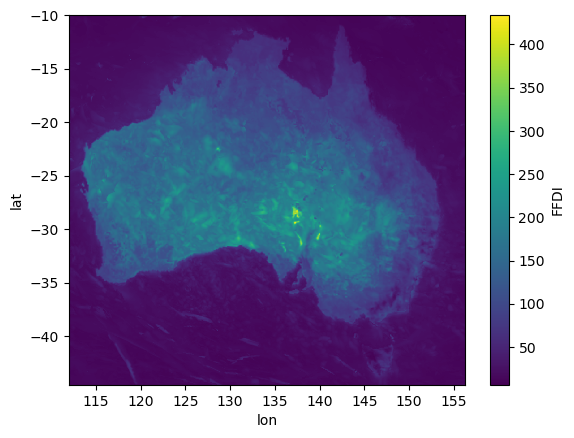

In [36]:
# First 20 points are nan due to the way DI is computed (see XCLIM)
ds1=xr.open_zarr('/g/data/ia39/ncra/fire/tmp/'+model_name[0]+'_FFDI.zarr')
ds1.FFDI.isel(time=slice(19,None)).max('time',skipna=False).plot()
#ds1.FFDI.isel(lon=200,lat=300).plot()
ds1

In [ ]:
%%time
zfile='/g/data/ia39/ncra/fire/tmp/'+model_name[0]+'_FFDI.zarr'
!tar -czvf {zfile}.tar.gz {zfile}

tar: Removing leading `/' from member names
/g/data/ia39/ncra/fire/tmpAGCD-05i_CSIRO_EC-Earth3_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1_day_FFDI.zarr/
/g/data/ia39/ncra/fire/tmpAGCD-05i_CSIRO_EC-Earth3_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1_day_FFDI.zarr/FFDI/
/g/data/ia39/ncra/fire/tmpAGCD-05i_CSIRO_EC-Earth3_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1_day_FFDI.zarr/FFDI/6.20.0
/g/data/ia39/ncra/fire/tmpAGCD-05i_CSIRO_EC-Earth3_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1_day_FFDI.zarr/FFDI/0.16.0
/g/data/ia39/ncra/fire/tmpAGCD-05i_CSIRO_EC-Earth3_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1_day_FFDI.zarr/FFDI/3.10.0
/g/data/ia39/ncra/fire/tmpAGCD-05i_CSIRO_EC-Earth3_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1_day_FFDI.zarr/FFDI/16.1.0
/g/data/ia39/ncra/fire/tmpAGCD-05i_CSIRO_EC-Earth3_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1_day_FFDI.zarr/FFDI/11.0.0
/g/data/ia39/ncra/fire/tmpAGCD-05i_CSIRO_EC-Earth3_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1_day_FFDI.zarr/FFDI/14.2.0
/g/data/ia39/ncra/fire/tmpAGCD-05i_CSIRO_EC-Earth3_ssp370_r1i1p1f1_CC

In [ ]:
# First 20 points are nan due to the way DI is computed (see XCLIM)
print(zfile)
ds2=xr.open_zarr(zfile+'.tar.gz')
ds2.FFDI.isel(time=slice(19,None)).max('time',skipna=False).plot()
ds2

## Extras 

In [68]:
#client.shutdown()